In [ ]:
import pandas as pd
import random 
from string import ascii_uppercase

def random_string_generator(n, k):
    random_strings = []
    for _ in range(n):
        random_strings.append(''.join(random.choice(ascii_uppercase) for i in range(k)))
    return random_strings

def random_ints_generator(n, max_val=1000):
    return [int(max_val*random.random())+1 for i in range(n)]

N_TRAIN = 1000
data = pd.DataFrame(columns=['image_filepath','mask_filepath','width','height','image_id'])
data['image_filepath'] = random_string_generator(N_TRAIN, 10)
data['mask_filepath'] = random_string_generator(N_TRAIN, 10)
data['width'] = random_ints_generator(N_TRAIN, 100)
data['height'] = random_ints_generator(N_TRAIN, 100)
data['image_id'] = random_ints_generator(N_TRAIN, 10000)
display(data.head())
data.to_csv('/mnt/ml-team/dsb_2018/kuba/mocked_data/metadata/train.csv',index=None)

N_TEST = 100
data = pd.DataFrame(columns=['image_filepath','width','height','image_id'])
data['image_filepath'] = random_string_generator(N_TEST, 10)
data['width'] = random_ints_generator(N_TEST, 100)
data['height'] = random_ints_generator(N_TEST, 100)
data['image_id'] = random_ints_generator(N_TEST, 10000)
display(data.head())
data.to_csv('/mnt/ml-team/dsb_2018/kuba/mocked_data/metadata/test.csv',index=None)

In [ ]:
data.describe()

In [ ]:
! ls /mnt/ml-team/dsb_2018/data/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
img = plt.imread('/mnt/ml-team/dsb_2018/kuba/mocked_data/masks_overlayed/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png')

In [ ]:
plt.imshow(img)

In [6]:
submission = pd.read_csv('/mnt/ml-team/dsb_2018/data/stage1_sample_submission.csv')
submission.head()

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,1 1
1,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,1 1
2,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...,1 1
3,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,1 1
4,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,1 1


In [ ]:
submission['EncodedPixels'].values

In [7]:
import pandas as pd
meta = pd.read_csv('/mnt/ml-team/dsb_2018/files/stage1_metadata.csv')
meta_test = meta[meta['is_train']==0]
meta_test.head()

,ImageId,file_path_image,file_path_masks,file_path_mask,is_train,width,height,n_nuclei
670,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,/mnt/ml-team/dsb_2018/data/stage1_test/0114f48...,NaN,NaN,0,256,256,NaN
671,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,/mnt/ml-team/dsb_2018/data/stage1_test/0999dab...,NaN,NaN,0,253,519,NaN
672,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...,/mnt/ml-team/dsb_2018/data/stage1_test/0a849e0...,NaN,NaN,0,256,256,NaN
673,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,/mnt/ml-team/dsb_2018/data/stage1_test/0e132f7...,NaN,NaN,0,256,256,NaN
674,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,/mnt/ml-team/dsb_2018/data/stage1_test/0ed3555...,NaN,NaN,0,256,256,NaN


In [8]:
submit = pd.read_csv('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/dummy_pipeline/submission.csv')
submit.head()

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,1 65536
1,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,1 131307
2,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...,1 65536
3,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,1 65536
4,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,1 65536


In [ ]:
img = plt.imread(meta['file_path_mask'].values[0])
plt.imshow(img)

In [55]:
import numpy as np
from metrics import intersection_over_union, intersection_over_union_thresholds
y_true = [(np.zeros((256,256))).astype(np.uint8)]
y_pred = [(np.zeros((256,256))).astype(np.uint8)]
y_true[0][77:250,77:250] = 1
y_pred[0][1:250,1:250] = 1
intersection_over_union(y_true, y_pred), intersection_over_union_thresholds(y_true, y_pred)

100%|██████████| 1/1 [00:00<00:00, 178.12it/s]


(0.48271802067708586, 0.0)

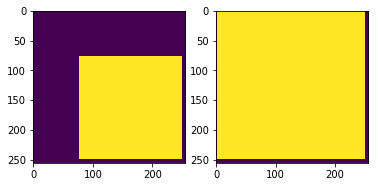

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(y_true[0])
plt.subplot(1,2,2)
plt.imshow(y_pred[0])

In [28]:
img = plt.imread('/mnt/ml-team/dsb_2018/files/masks_overlayed/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png')

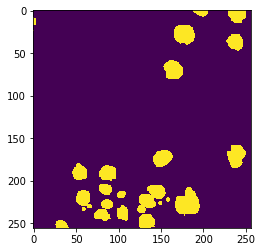

In [46]:
plt.imshow(img[:,:,0]>0.5)
plt.show()

In [42]:
(img[:,:,0] > 0.5).mean()

0.0872039794921875